In [1]:
!pip install sqlalchemy

In [ ]:
!pip install -q smolagents


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from sqlalchemy import Table, Column, Integer, String, Float, Date, MetaData, create_engine, insert
from datetime import datetime
from sqlalchemy import (
    create_engine,
    MetaData,
    Table,
    Column,
    String,
    Integer,
    Float,
    insert,
    inspect,
    text,
)

In [5]:
from smolagents import tool
from smolagents import CodeAgent, HfApiModel

@tool
def sql_engine(query: str) -> str:
    output = ""
    with engine.connect() as con:
        rows = con.execute(text(query))
        for row in rows:
            output += "\n" + str(row)
    return output

In [8]:
engine = create_engine("sqlite:///:memory:")  
metadata_obj = MetaData()

# Table 1: Employees
employees = Table(
    "employees", metadata_obj,
    Column("id", Integer, primary_key=True),
    Column("name", String(50), nullable=False),
    Column("department", String(50), nullable=False),
    Column("salary", Float, nullable=False),
    Column("hire_date", Date, nullable=False)
)

# Table 2: Departments
departments = Table(
    "departments", metadata_obj,
    Column("id", Integer, primary_key=True),
    Column("name", String(50), nullable=False, unique=True),
    Column("manager", String(50), nullable=False)
)

metadata_obj.create_all(engine)

employee_rows = [
    {"id": 1, "name": "Alice", "department": "Sales", "salary": 50000, "hire_date": datetime.strptime("2021-01-15", "%Y-%m-%d").date()},
    {"id": 2, "name": "Bob", "department": "Engineering", "salary": 70000, "hire_date": datetime.strptime("2020-06-10", "%Y-%m-%d").date()},
    {"id": 3, "name": "Charlie", "department": "Marketing", "salary": 60000, "hire_date": datetime.strptime("2022-03-20", "%Y-%m-%d").date()}
]

department_rows = [
    {"id": 1, "name": "Sales", "manager": "Alice"},
    {"id": 2, "name": "Engineering", "manager": "Bob"},
    {"id": 3, "name": "Marketing", "manager": "Charlie"}
]

with engine.begin() as connection:
    connection.execute(insert(employees), employee_rows)
    connection.execute(insert(departments), department_rows)

In [17]:
try:
    updated_description = """Allows you to perform SQL queries on the table. Beware that this tool's output is a string representation of the execution output.
It can use the following tables:"""

    inspector = inspect(engine)

    for table in ["employees", "departments"]:
        try:
            columns_info = [(col["name"], col["type"]) for col in inspector.get_columns(table)]
            table_description = f"\n\nTable '{table}':\n"
            table_description += "Columns:\n" + "\n".join([f"  - {name}: {col_type}" for name, col_type in columns_info])
            updated_description += table_description
        except Exception as e:
            updated_description += f"\n\nError retrieving columns for table '{table}': {str(e)}"

    print(updated_description)

except Exception as e:
    print(f"An error occurred while inspecting the database: {str(e)}")

Allows you to perform SQL queries on the table. Beware that this tool's output is a string representation of the execution output.
It can use the following tables:

Table 'employees':
Columns:
  - id: INTEGER
  - name: VARCHAR(50)
  - department: VARCHAR(50)
  - salary: FLOAT
  - hire_date: DATE

Table 'departments':
Columns:
  - id: INTEGER
  - name: VARCHAR(50)
  - manager: VARCHAR(50)


In [11]:
sql_engine.description = updated_description

agent = CodeAgent(
    tools=[sql_engine],
    model=HfApiModel("Qwen/Qwen2.5-72B-Instruct"),
)

agent.run("Which employee got more total salary?")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Which employee got more total salary?                                                                           │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Query to calculate total salary for each employee                                                              
  query = "SELECT name, SUM(salary) as total_salary FROM employees GROUP BY name ORDER BY total_salary DESC LIMIT  
  1;"                                                                                                              
  result = sql_engine(query=query)                                                                                 
  print(result)                                                                                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:

('Bob', 70000.0)

Out: None

[Step 0: Duration 5.01 seconds| Input tokens: 2,161 | Output tokens: 106]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Extract name of the employee with the maximum total salary                                                     
  max_salary_employee = 'Bob'                                                                                      
  final_answer(max_salary_employee)                                                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Bob

[Step 1: Duration 2.70 seconds| Input tokens: 4,554 | Output tokens: 166]

'Bob'

In [12]:
agent.run("Show me all employees in the Sales department.")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Show me all employees in the Sales department.                                                                  │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  query_result = sql_engine(query="SELECT * FROM employees WHERE department = 'Sales'")                            
  print(query_result)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:

(1, 'Alice', 'Sales', 50000.0, '2021-01-15')

Out: None

[Step 0: Duration 4.90 seconds| Input tokens: 2,163 | Output tokens: 59]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer([{'id': 1, 'name': 'Alice', 'department': 'Sales', 'salary': 50000.0, 'hire_date': '2021-01-15'}])  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: [{'id': 1, 'name': 'Alice', 'department': 'Sales', 'salary': 50000.0, 'hire_date': 
'2021-01-15'}]

[Step 1: Duration 3.89 seconds| Input tokens: 4,504 | Output tokens: 144]

[{'id': 1,
  'name': 'Alice',
  'department': 'Sales',
  'salary': 50000.0,
  'hire_date': '2021-01-15'}]

In [13]:
agent.run("Who is the manager of the Engineering department?")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Who is the manager of the Engineering department?                                                               │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  query = "SELECT manager FROM departments WHERE name = 'Engineering'"                                             
  result = sql_engine(query=query)                                                                                 
  print(result)                                                                                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:

('Bob',)

Out: None

[Step 0: Duration 3.12 seconds| Input tokens: 2,163 | Output tokens: 64]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("Bob")                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Bob

[Step 1: Duration 2.28 seconds| Input tokens: 4,484 | Output tokens: 104]

'Bob'

In [14]:
agent.run("List all employees hired after 2021-01-01.")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ List all employees hired after 2021-01-01.                                                                      │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  query = "SELECT * FROM employees WHERE hire_date > '2021-01-01'"                                                 
  new_employees = sql_engine(query=query)                                                                          
  print(new_employees)                                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:

(1, 'Alice', 'Sales', 50000.0, '2021-01-15')
(3, 'Charlie', 'Marketing', 60000.0, '2022-03-20')

Out: None

[Step 0: Duration 3.54 seconds| Input tokens: 2,171 | Output tokens: 77]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(new_employees)                                                                                      
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 
(1, 'Alice', 'Sales', 50000.0, '2021-01-15')
(3, 'Charlie', 'Marketing', 60000.0, '2022-03-20')

[Step 1: Duration 1.50 seconds| Input tokens: 4,584 | Output tokens: 112]

"\n(1, 'Alice', 'Sales', 50000.0, '2021-01-15')\n(3, 'Charlie', 'Marketing', 60000.0, '2022-03-20')"

In [16]:
agent.run("What is the total salary expense for the Sales department?")


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ What is the total salary expense for the Sales department?                                                      │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  result = sql_engine(query="SELECT SUM(salary) as total_salary FROM employees WHERE department = 'Sales'")        
  print(result)                                                                                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:

(50000.0,)

Out: None

[Step 0: Duration 2.91 seconds| Input tokens: 2,165 | Output tokens: 70]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  result = sql_engine(query="SELECT SUM(salary) as total_salary FROM employees WHERE department = 'Sales'")        
  total_salary = result[0][0]                                                                                      
  print(total_salary)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:



Out: None

[Step 1: Duration 4.24 seconds| Input tokens: 4,502 | Output tokens: 171]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  result = sql_engine(query="SELECT SUM(salary) as total_salary FROM employees WHERE department = 'Sales'")        
  total_salary = result[0][0]                                                                                      
  final_answer(total_salary)                                                                                       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 

[Step 2: Duration 3.57 seconds| Input tokens: 7,044 | Output tokens: 257]

'\n'

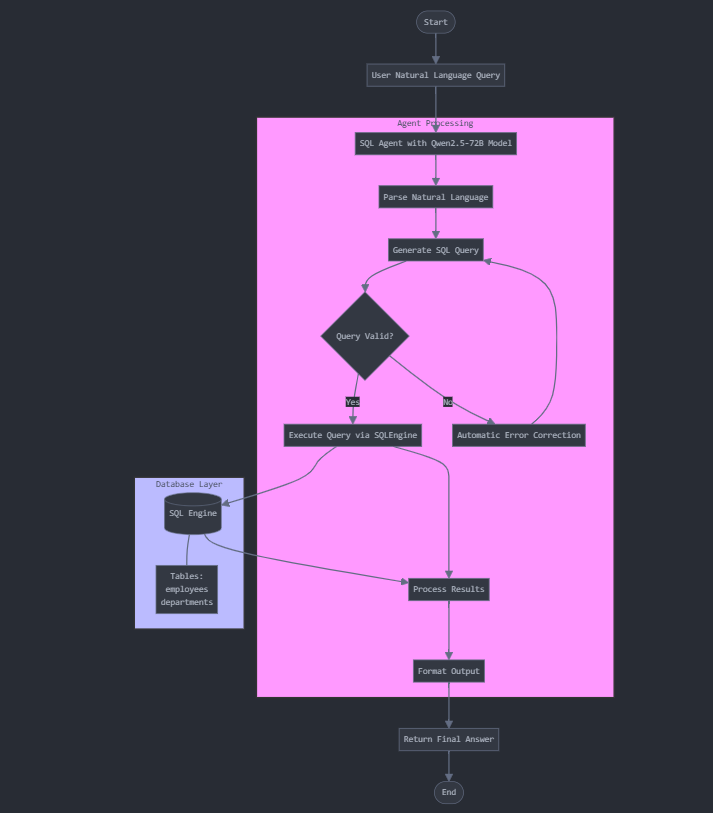